# First steps with ReservoirPy

In [1]:
CSV_FILE = "../../data/synthetic_bph_1/simulation.csv"
USE_NOISY_DATA = False

In [2]:
import sys

TOOL_PATH = "../../tools"
sys.path.append(TOOL_PATH)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from reservoirpy.nodes import Reservoir, Ridge, Input, ScikitLearnNode

from time_series_modules import train_test_split_on_series, TimeSerieShapeChanger

## Data Loading

In [6]:
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")
data

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,y,y_obs
0,1,0,0.578900,2.609469,1.182835,1.163621,0.337061,0.425037,-0.431840,-0.357768,-1.898849e-01,-0.232450,0.831012,1.352299,-0.516725,-0.530378,0,-0.377299,-0.446602
1,1,1,-0.722880,0.632410,1.063808,1.213479,0.336570,0.027890,-0.291742,-0.231186,-6.353905e-02,-0.046091,1.100089,0.659184,-0.197166,-0.202305,0,-0.351356,-0.336197
2,1,2,-2.024659,-4.894554,0.994182,1.007263,0.335097,0.190370,-0.164976,-0.228072,-1.473688e-02,-0.027549,1.406843,1.589057,-0.054419,-0.062498,0,-0.465150,-0.305957
3,1,3,-3.326438,-1.686564,0.944782,1.016037,0.332642,0.353213,-0.050273,-0.054755,-3.055779e-03,-0.002254,1.751273,1.588178,-0.013368,-0.002160,0,-0.593820,-0.562556
4,1,4,-4.628218,-5.122320,0.906464,0.815443,0.329205,0.389886,0.053514,0.104324,-6.179594e-04,-0.023248,2.133381,2.310414,-0.003183,-0.018556,0,-0.724237,-0.768777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,500,46,-23.332007,-23.355913,-4.344100,-4.414434,-0.173962,-0.122074,-1.178537,-1.380993,-2.045994e-33,-0.005981,13.776952,13.618513,-1.257165,-1.260118,1,-14.103343,-13.962535
25496,500,47,-23.805504,-25.684027,-4.367756,-4.504144,-0.225636,-0.238187,-1.177882,-1.235860,-3.952067e-34,0.009649,14.593799,14.807169,-1.257178,-1.253582,1,-14.908790,-14.811023
25497,500,48,-24.279001,-24.921407,-4.390925,-4.286035,-0.278421,-0.347200,-1.177290,-1.228622,-7.633860e-35,-0.002082,15.434169,15.402741,-1.257188,-1.264389,1,-15.742044,-15.744676
25498,500,49,-24.752498,-24.910869,-4.413625,-4.399454,-0.332318,-0.325558,-1.176754,-1.040624,-1.474566e-35,0.033597,16.298063,16.347750,-1.257196,-1.251337,1,-16.603254,-16.663303


In [7]:
serie_column_name = "individus"
timestep_column_name = "temps"

if USE_NOISY_DATA:
    y_labels = ["y_obs"]
    x_labels = [c for c in data.columns if c.startswith("x") and c.endswith("_obs")]
else:
    y_labels = ["y"]
    x_labels = [c for c in data.columns if c.startswith("x") and not c.endswith("_obs")]

### Spliting on series

In [8]:
data_train, data_test = train_test_split_on_series(
    data,
    serie_column_name,
    timestep_column_name,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

In [9]:
data_train

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,y,y_obs
51,2,0,0.239470,3.623647,0.689672,0.680694,0.022125,0.039108,-2.141046,-2.200175,4.847082e-02,0.054354,0.023946,-1.163267,-0.456192,-0.446443,1,0.726698,0.757364
52,2,1,0.425554,1.455243,-0.552046,-0.461030,0.021768,-0.055345,-2.015104,-2.176309,8.113353e-02,0.085076,0.040596,0.086850,-0.545806,-0.544588,1,0.696121,0.709414
53,2,2,0.611639,2.236909,-1.278405,-1.132379,0.020697,0.169975,-1.901148,-2.040687,9.339606e-02,0.069012,0.061617,-0.246386,-0.628761,-0.633038,1,0.666024,0.553910
54,2,3,0.797723,-0.224566,-1.793765,-1.756710,0.018911,-0.049667,-1.798035,-1.806280,9.622985e-02,0.079222,0.087006,-0.204201,-0.700240,-0.707350,1,0.639945,0.703938
55,2,4,0.983808,1.571825,-2.193509,-2.235005,0.016411,0.049775,-1.704736,-1.713922,9.680213e-02,0.084837,0.116766,0.429388,-0.758125,-0.782778,1,0.615497,0.648005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,500,46,-23.332007,-23.355913,-4.344100,-4.414434,-0.173962,-0.122074,-1.178537,-1.380993,-2.045994e-33,-0.005981,13.776952,13.618513,-1.257165,-1.260118,1,-14.103343,-13.962535
25496,500,47,-23.805504,-25.684027,-4.367756,-4.504144,-0.225636,-0.238187,-1.177882,-1.235860,-3.952067e-34,0.009649,14.593799,14.807169,-1.257178,-1.253582,1,-14.908790,-14.811023
25497,500,48,-24.279001,-24.921407,-4.390925,-4.286035,-0.278421,-0.347200,-1.177290,-1.228622,-7.633860e-35,-0.002082,15.434169,15.402741,-1.257188,-1.264389,1,-15.742044,-15.744676
25498,500,49,-24.752498,-24.910869,-4.413625,-4.399454,-0.332318,-0.325558,-1.176754,-1.040624,-1.474566e-35,0.033597,16.298063,16.347750,-1.257196,-1.251337,1,-16.603254,-16.663303


In [10]:
data_test

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,y,y_obs
0,1,0,0.578900,2.609469,1.182835,1.163621,0.337061,0.425037,-0.431840,-0.357768,-1.898849e-01,-0.232450,0.831012,1.352299,-0.516725,-0.530378,0,-0.377299,-0.446602
1,1,1,-0.722880,0.632410,1.063808,1.213479,0.336570,0.027890,-0.291742,-0.231186,-6.353905e-02,-0.046091,1.100089,0.659184,-0.197166,-0.202305,0,-0.351356,-0.336197
2,1,2,-2.024659,-4.894554,0.994182,1.007263,0.335097,0.190370,-0.164976,-0.228072,-1.473688e-02,-0.027549,1.406843,1.589057,-0.054419,-0.062498,0,-0.465150,-0.305957
3,1,3,-3.326438,-1.686564,0.944782,1.016037,0.332642,0.353213,-0.050273,-0.054755,-3.055779e-03,-0.002254,1.751273,1.588178,-0.013368,-0.002160,0,-0.593820,-0.562556
4,1,4,-4.628218,-5.122320,0.906464,0.815443,0.329205,0.389886,0.053514,0.104324,-6.179594e-04,-0.023248,2.133381,2.310414,-0.003183,-0.018556,0,-0.724237,-0.768777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25393,498,46,-20.042683,-22.991784,-4.305813,-4.285416,-1.008625,-0.835657,1.413129,1.469617,-6.189255e-12,-0.000800,10.165008,9.474388,-1.667517,-1.657866,1,-15.239867,-15.123631
25394,498,47,-20.476856,-22.271010,-4.334574,-4.305548,-1.095560,-0.942135,1.414368,1.429053,-3.501757e-12,-0.014008,10.415454,10.435068,-1.667517,-1.665445,1,-15.694905,-15.819743
25395,498,48,-20.911029,-21.861396,-4.362741,-4.556842,-1.184364,-1.133681,1.415489,1.429348,-1.981225e-12,-0.023474,10.668949,11.156696,-1.667517,-1.655116,1,-16.157002,-16.170034
25396,498,49,-21.345202,-22.647592,-4.390339,-4.488709,-1.275039,-1.181088,1.416503,1.511823,-1.120937e-12,-0.006141,10.925491,11.154988,-1.667517,-1.645091,1,-16.626182,-16.442007


## First run (no pipeline)

### Data scaling and formating

In [11]:
column_order = [serie_column_name, timestep_column_name] + x_labels + y_labels
sort_columns = [serie_column_name, timestep_column_name]

data_train = data_train[column_order].sort_values(by=sort_columns)
data_test = data_test[column_order].sort_values(by=sort_columns)

In [25]:
x_train = data_train[x_labels]
y_train = data_train[y_labels]
N_series_train = len(data_train[serie_column_name].unique())
N_times_train = len(data_train[timestep_column_name].unique())

print(x_train.shape, y_train.shape, N_series_train, N_times_train)

(20400, 8) (20400, 1) 400 51


In [26]:
x_test = data_test[x_labels]
y_test = data_test[y_labels]
N_series_test = len(data_test[serie_column_name].unique())
N_times_test = len(data_test[timestep_column_name].unique())

print(x_test.shape, y_test.shape, N_series_test, N_times_test)

(5100, 8) (5100, 1) 100 51


In [13]:
x_scaler = StandardScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [14]:
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
# we will "inverse_transform" the prediction instead

https://reservoirpy.readthedocs.io/en/latest/user_guide/quickstart.html#A-note-on-data-formats

> In ReservoirPy, all data are stored in Numpy arrays. It includes parameters of ReservoirPy Nodes and their input data. ReservoirPy uses only Numpy and Scipy for all computations.

> All timeseries, from input data to reservoir’s activations, are formatted the same way: they must be Numpy arrays of shape `(timesteps, features)`. For instance, a timeseries composed of two variables samples over 100 timesteps would be stored in an array of shape `(100, 2)`. Single timesteps must also comply to this convention. A single timestep of the same 2-dimensional timeseries would be an array of shape `(1, 2)`. Make sure to always comply with this formatting otherwise you might obtain unexpected results, or raise an error.

> When training or running over several independent timeseries, for instance using several audio signals or several sine wave at different frequency, an accepted shape may be `(series, timesteps, features)`. In that case, input data may be an array where all series have the same length `timesteps`, or a list of arrays storing timeseries of different lengths.

In [15]:
x_train_3D = x_train_scaled.reshape([N_series_train, N_times_train, len(x_labels)])
x_test_3D = x_test_scaled.reshape([N_series_test, N_times_test, len(x_labels)])
y_train_3D = y_train_scaled.reshape([N_series_train, N_times_train, len(y_labels)])

### Training a Reservoir model

In [27]:
data = Input(input_dim=len(x_labels))
reservoir = Reservoir(100, lr=0.3, sr=1.1)
readout = Ridge(ridge=1e-5)

esn = data >> reservoir >> readout

In [28]:
esn.fit(x_train_3D, y_train_3D)

Running Model-3:   0%|          | 0/400 [00:00<?, ?it/s]

Running Model-3: 51it [00:00, 2762.23it/s]            
Running Model-3: 51it [00:00, 1628.52it/s]            
Running Model-3: 51it [00:00, 2987.06it/s]            
Running Model-3: 51it [00:00, 2561.70it/s]            24.26it/s]
Running Model-3: 51it [00:00, 1151.49it/s]            
Running Model-3: 51it [00:00, 3682.57it/s]            
Running Model-3: 51it [00:00, 2159.65it/s]            22.83it/s]
Running Model-3: 51it [00:00, 1411.26it/s]            
Running Model-3: 51it [00:00, 1223.52it/s]            
Running Model-3: 51it [00:00, 1159.19it/s]            21.37it/s]
Running Model-3: 51it [00:00, 1136.79it/s]            
Running Model-3: 51it [00:00, 1079.78it/s]            
Running Model-3: 51it [00:00, 2205.39it/s]             18.25it/s]
Running Model-3: 51it [00:00, 2354.12it/s]            
Running Model-3: 51it [00:00, 2120.27it/s]            
Running Model-3: 51it [00:00, 1179.89it/s]             20.37it/s]
Running Model-3: 51it [00:00, 1925.15it/s]            
Running Model

Fitting node Ridge-1...


'Model-3': Model('Input-1', 'Reservoir-1', 'Ridge-1')

### Prediction

In [29]:
y_hat_3D = esn.run(x_test_3D)

Running Model-3: 51it [00:00, 3023.76it/s]            
Running Model-3: 51it [00:00, 3229.94it/s]            
Running Model-3: 51it [00:00, 3548.54it/s]            
Running Model-3: 51it [00:00, 1638.66it/s]            
Running Model-3: 51it [00:00, 3585.42it/s]            
Running Model-3: 51it [00:00, 2599.30it/s]            
Running Model-3: 51it [00:00, 2966.68it/s]            
Running Model-3: 51it [00:00, 3887.57it/s]            
Running Model-3: 51it [00:00, 2321.39it/s]            
Running Model-3: 51it [00:00, 3106.12it/s]            
Running Model-3: 51it [00:00, 3719.58it/s]            
Running Model-3: 51it [00:00, 3325.45it/s]            
Running Model-3: 51it [00:00, 2700.88it/s]            
Running Model-3: 51it [00:00, 2550.70it/s]            
Running Model-3: 51it [00:00, 2359.29it/s]            
Running Model-3: 51it [00:00, 2606.01it/s]            
Running Model-3: 51it [00:00, 1222.06it/s]            
Running Model-3: 51it [00:00, 3108.92it/s]            
Running Mo

In [30]:
print(type(y_hat_3D))
print(len(y_hat_3D))
print(type(y_hat_3D[0]))
print(len(y_hat_3D[0]))

<class 'list'>
100
<class 'numpy.ndarray'>
51


OK… au lieu de récupérer un tenseur de taille `(series, timesteps, target)`, on récupère une liste de taille `series` avec des tenseurs de taille `(timesteps, target)`.

Donc avec `np.array` on retrouve le tenseur attendu.


In [31]:
y_hat_scaled = np.array(y_hat_3D).reshape([N_series_test * N_times_test, len(y_labels)])
y_hat = y_scaler.inverse_transform(y_hat_scaled)

In [32]:
mean_squared_error(y_test, y_hat)

np.float64(371.18985268945863)

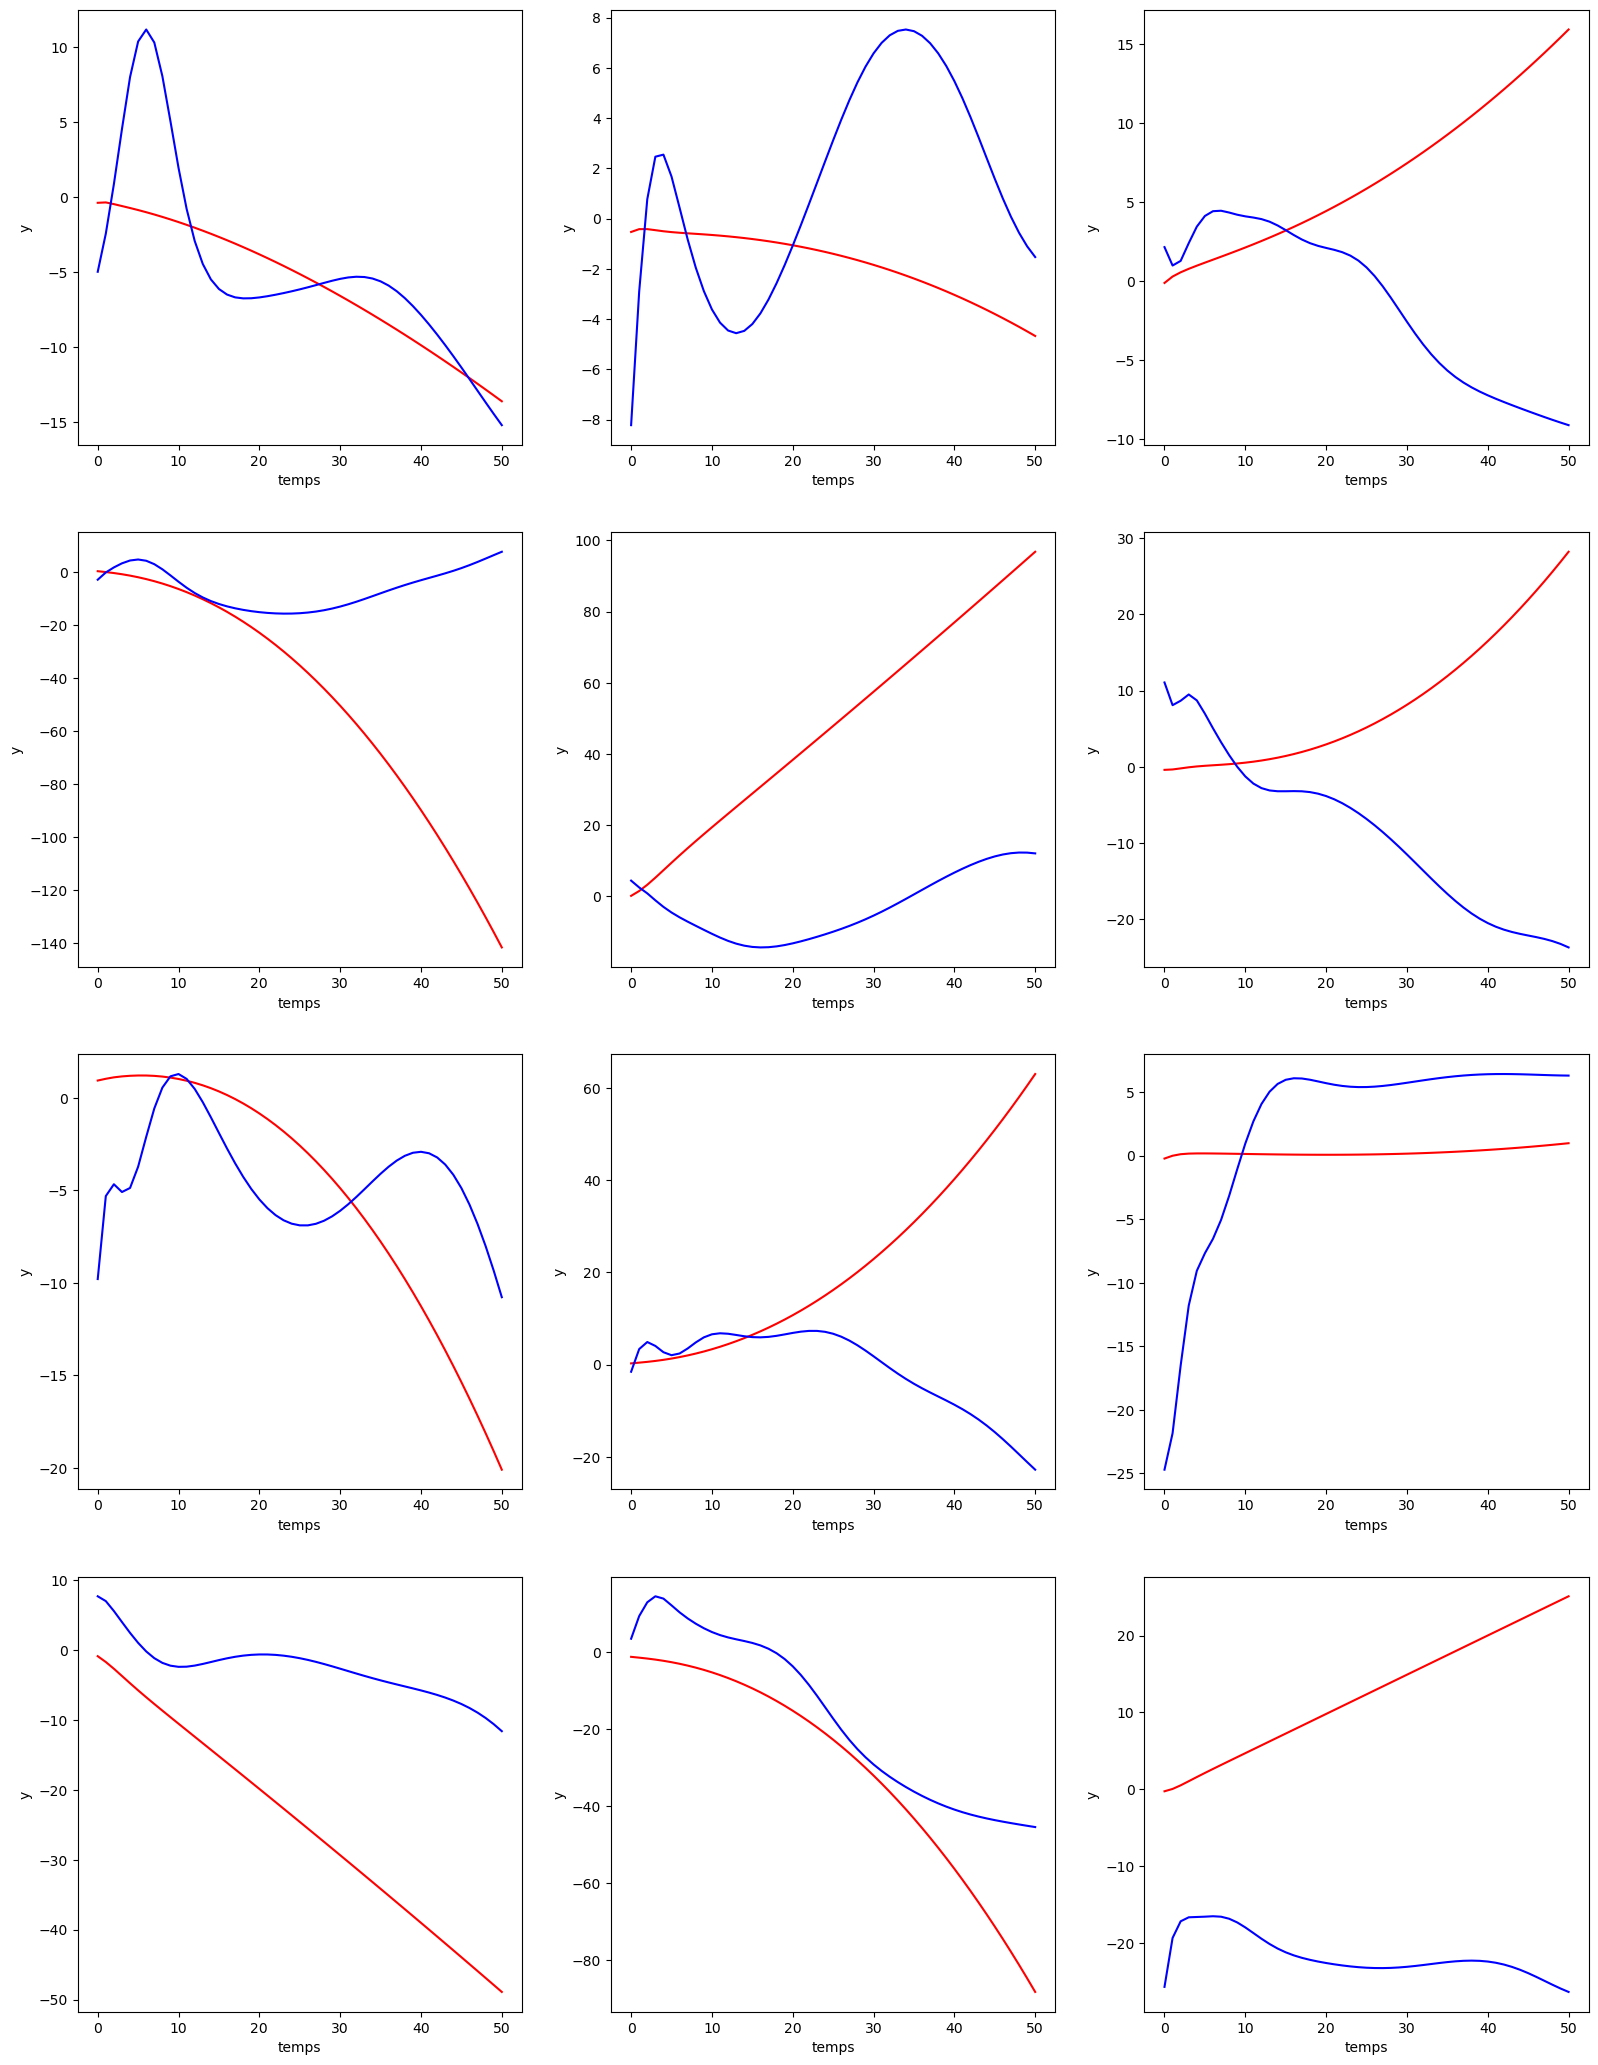

In [33]:
from math import ceil

data_test["y_hat"] = y_hat
series_test = data_test[serie_column_name].unique()[:12]


NCOLS = 3
nrows = ceil(len(series_test) / NCOLS)


f, ax = plt.subplots(
    nrows=nrows,
    ncols=NCOLS,
    figsize=(6.5 * NCOLS, 6.5 * nrows),
)

for i_serie, serie in enumerate(series_test):
    irow = i_serie // NCOLS
    icol = i_serie % NCOLS
    data_plot = data_test[data_test[serie_column_name] == serie]

    sns.lineplot(
        x=data_plot[timestep_column_name],
        y=data_plot["y"],
        ax=ax[irow, icol],
        color="red",
    )
    sns.lineplot(
        x=data_plot[timestep_column_name],
        y=data_plot["y_hat"],
        ax=ax[irow, icol],
        color="blue",
    )

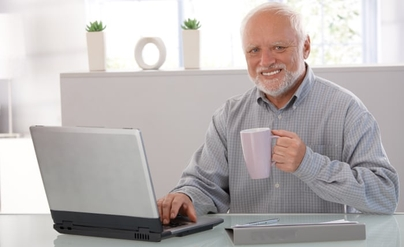

## Scikit-Learn pipeline

In [14]:
# ts_shape_changer = TimeSerieShapeChanger(serie_column_name, timestep_column_name)


# def func_forward(x):
#     return ts_shape_changer.df2D_to_array3D(x)


# def func_backward(x):
#     return ts_shape_changer.array3D_to_df2D(x)


# pipeline_transf_X = Pipeline(
#     [("Scaler", StandardScaler()), ("DimChange", func_forward)]
# )

# pipeline_transf_y = Pipeline(
#     [("Scaler", StandardScaler()), ("DimChange", func_forward)]
# )


# reservoir = Reservoir(100, lr=0.3, sr=1.1)
# readout = Ridge(ridge=1e-6)

# esn = reservoir >> readout


# regressor = TransformedTargetRegressor(regressor=esn, transformer=pipeline_transf_y)


# pipeline = Pipeline(
#     [("transf_X", pipeline_transf_X), ("transf_target_regressor", regressor)]
# )